### NOTE: Neither the lines of code nor text have been proofread and some of the writing have been taken directly from the OpenCV documentation

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Introduction to Features

Features enable us identify patches which can be put together to form a complete image. For more, see:
<br>
https://docs.opencv.org/3.4/df/d54/tutorial_py_features_meaning.html

Three common features are corners, edges, and flats.

### Detecting Corners

Corners are good features to detect; the above website illustrates why. Now there are different ways to detect them (with OpenCV), which include:

**Harris Corner Detection**

See https://docs.opencv.org/3.4/dc/d0d/tutorial_py_features_harris.html

**Shi-Tomasi Corner Detection**

This gives better results than Harris Corner detection (although the former is based on the latter). For more, see https://docs.opencv.org/3.4/d4/d8c/tutorial_py_shi_tomasi.html

A problem with using corners as features is that they are not scale invariant. In other words, the window has to be of the correct size in order for the corner to be recognisable. If the corner is zoomed into, it will become too large for the window and the corner as a feature, seizes to be a corner and becomes a flat feature.

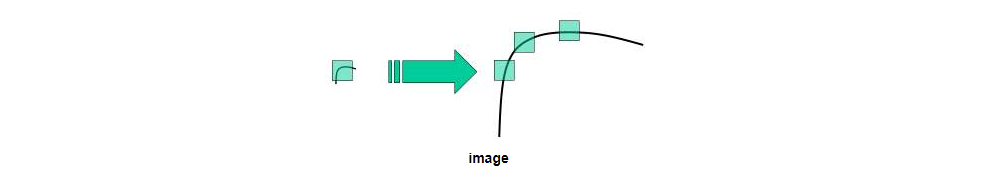

As was illustrated in the introductory reference, flats are poor features; therefore, to resolve the problem, we scale the window until the flat feature seizes to be flat and becomes a *keypoint*.

### Finding Keypoints

Keypoints can be found using:

**Scale-Invariant Feature Transform (SIFT)**

See https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html

**Speeded-Up Robust Features (SURF)**

Although SIFT is good, it is also slow. SURF is faster. For more, see https://docs.opencv.org/3.4/df/dd2/tutorial_py_surf_intro.html

### Faster Detection of Corners

**Features from Accelerated Segment Test (FAST)**

https://docs.opencv.org/3.4/df/d0c/tutorial_py_fast.html

### Others

**Binary Robust Independent Elementary Features (BRIEF)**

This does not find features but speeds up the detection of features by feature detectors.

https://docs.opencv.org/3.4/dc/d7d/tutorial_py_brief.html

**Oriented FAST and Rotated BRIEF (ORB)**

*Free* alternative to SIFT or SURF

https://docs.opencv.org/3.4/d1/d89/tutorial_py_orb.html

### Matching Features

Exactly what it says on the tin! Two ways of doing this are:

<ul>
    <li>Brute-Force Matcher</li>
    <li>FLANN-based Matcher</li>
</ul>

**Brute-Force Matcher**

Basically, it matches and uses distance calculation; it can be done by ORB or SIFT

<strong><em>Brute-Force Matcher Using ORB</em></strong>

I'll match a card from two photos

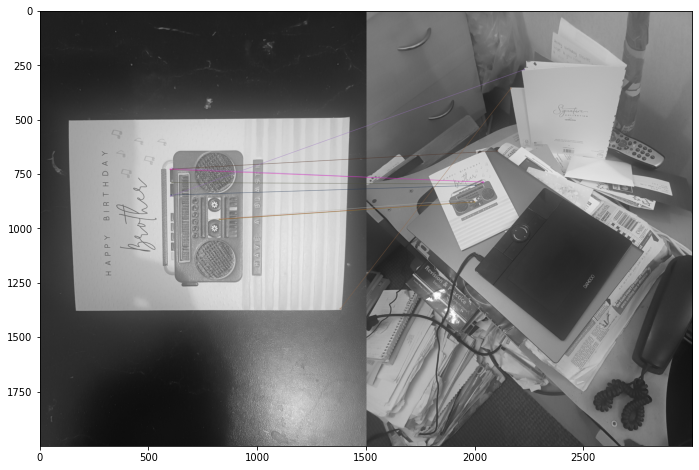

In [21]:
img1 = cv.imread('bank_images/test17b.jpg', cv.IMREAD_GRAYSCALE)   # query image
img2 = cv.imread('bank_images/test17.jpg', cv.IMREAD_GRAYSCALE)    # train image

# Initiate ORB detector
orb = cv.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(19,8))
plt.imshow(img3, cmap='gray')

Brute-Force Matcher Using SIFT

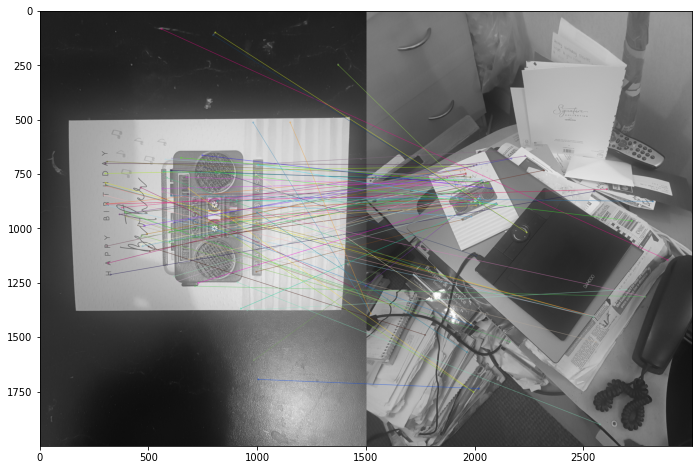

In [22]:
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
        
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15,8))
plt.imshow(img3, cmap='gray')

The results for the above two are not as 'accurate' as the examples at:
<br>
https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html

This is because we have included both *inliers* and *outliers*. Obviously, if the majority of matching lines are inliers then that increases confidence that the object in the query image is actually in the train image. Could be useful for trying to find something (or someone) in an image. Let's save this one

In [23]:
cv.imwrite('bank_images/test17mapped.jpg', img3)

True

**FLANN-based Matcher**

FLANN stands for **F**ast **L**ibrary for **A**pproximate **N**earest **N**eighbors; it contains a collection of algorithms optimized for fast nearest neighbor search in large datasets and for high dimensional features. It works faster than BFMatcher for large datasets. An example of its implementation can be found at https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html

**Feature Matching and Homography**

While it's good that if the majority of lines are inliers,that increases confidence that the object in the query image is in the train image, it's even better if that object in the train image can be enclosed in a rectangle of so, especially if that object in the train image is surrounded by other objects.

For that, we can combine feature matching technology with **calib3d module** (<code>cv.findHomography()</code>); the details of how this works can be found at https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html

An example of implementation is below

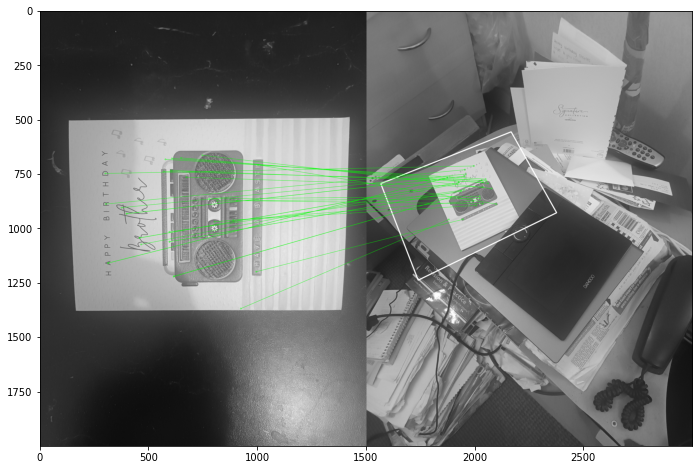

In [24]:
MIN_MATCH_COUNT = 10

# Initiate SIFT detector
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
        
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None
    
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.figure(figsize=(15,8))
plt.imshow(img3, cmap='gray')

Note now that the outliers have been excluded.

Let's save this!

In [25]:
cv.imwrite('bank_images/test17mappedandenclosed.jpg', img3)

True